In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import Image

# Skip until "Start Here"

In [2]:
dataset_dir = "C:/Users/Hannah/OneDrive/Documents/MIDS/207/Final_Project/mids_207_final_project/"
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "train",
  validation_split=0.2,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)
train_ds

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "train",
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


In [132]:
classes = train_ds.class_names
classes

['FAKE', 'REAL']

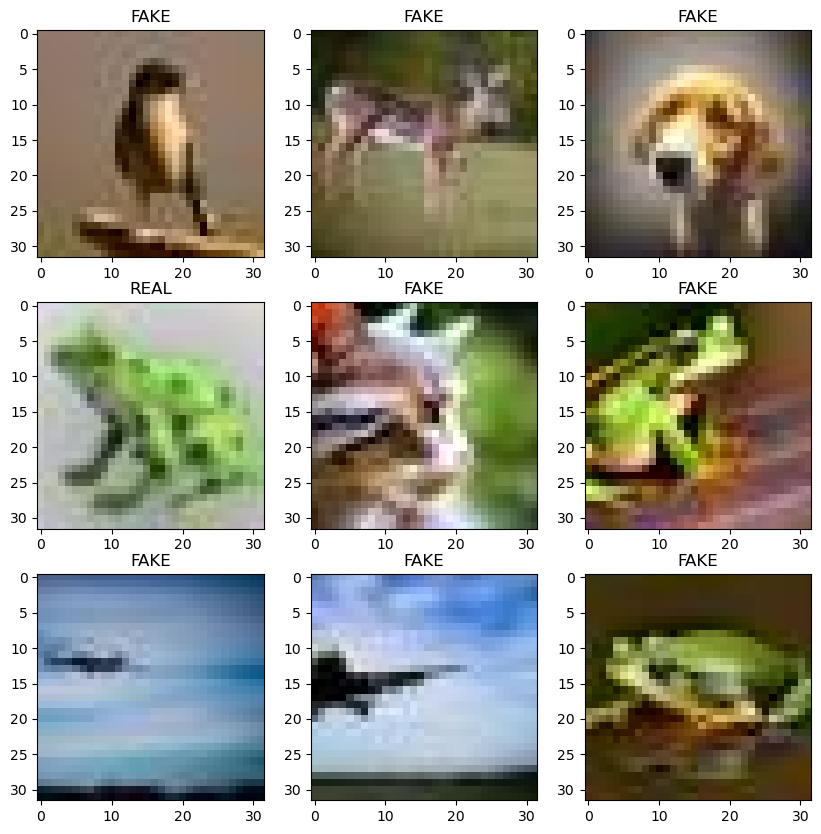

In [5]:
#first 9 images in training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    

In [6]:
#Rescaling images
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9725491


<_TakeDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
alist = list(train_ds)

# Start Here

# Load data

Loading it differently for Random Forest so that it is loaded in 1 batch

In [5]:
dataset_dir = "C:/Users/Hannah/OneDrive/Documents/MIDS/207/Final_Project/mids_207_final_project/"
img_height = 32
img_width = 32
batch_size = 500
train_ds_rf = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "train",
  validation_split=0.2,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width), 
  batch_size = 80000)
train_ds_rf

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
val_ds_rf = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "train",
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width), 
  batch_size = 20000)
val_ds_rf

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Converting Prefetched Datasets to numpy ndarrays to use in scikit-learn Random Forest Classifier

In [7]:
rf_train_list = list(train_ds_rf)

In [8]:
train_imgs = rf_train_list[0][0].numpy()
train_labels = rf_train_list[0][1].numpy()

In [9]:
norm_train_imgs = train_imgs/255.0
norm_train_imgs.shape

(80000, 32, 32, 3)

In [10]:
rf_val_list = list(val_ds_rf)
val_imgs = rf_val_list[0][0].numpy()
val_labels = rf_val_list[0][1].numpy()

In [11]:
norm_val_imgs = val_imgs/255.0
norm_val_imgs.shape

(20000, 32, 32, 3)

In [12]:
nsamples, nx, ny, nrgb = norm_train_imgs.shape
norm_train_imgs2 = norm_train_imgs.reshape((nsamples,nx*ny*nrgb))
norm_train_imgs2.shape

(80000, 3072)

In [13]:
nsamplesv, nxv, nyv, nrgbv = norm_val_imgs.shape
norm_val_imgs2 = norm_val_imgs.reshape((nsamplesv,nxv*nyv*nrgbv))
norm_val_imgs2.shape

(20000, 3072)

# EDA

In [14]:
classes = train_ds_rf.class_names
classes

['FAKE', 'REAL']

In [15]:
train_wordlabels = [classes[i] for i in train_labels]

In [16]:
label_counts = [train_wordlabels.count('REAL'),  train_wordlabels.count('FAKE')]
label_counts

[39985, 40015]

Text(0, 0.5, 'Count')

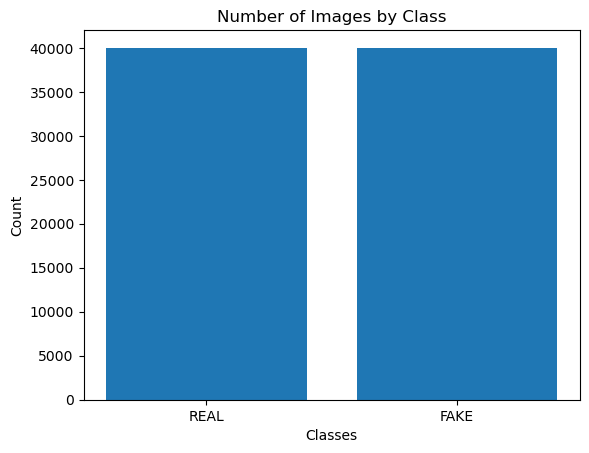

In [17]:
plt.bar(['REAL', 'FAKE'], label_counts)
plt.title("Number of Images by Class")
plt.xlabel("Classes")
plt.ylabel("Count")

In [18]:
real_imgs = train_imgs[train_labels == 1]
fake_imgs = train_imgs[train_labels == 0]
real_imgs.shape, fake_imgs.shape

((39985, 32, 32, 3), (40015, 32, 32, 3))

In [19]:
realimg_R = real_imgs[:,:,:,0].flatten()
realimg_G = real_imgs[:,:,:,1].flatten()
realimg_B = real_imgs[:,:,:,2].flatten()
realimg_R.shape

(40944640,)

In [20]:
fakeimg_R = fake_imgs[:,:,:,0].flatten()
fakeimg_G = fake_imgs[:,:,:,1].flatten()
fakeimg_B = fake_imgs[:,:,:,2].flatten()
fakeimg_R.shape

(40975360,)

[Text(0.5, 23.52222222222222, 'RGB Value'),
 Text(313.14267676767673, 0.5, 'Count'),
 Text(0.5, 1.0, 'Fake Images RGB')]

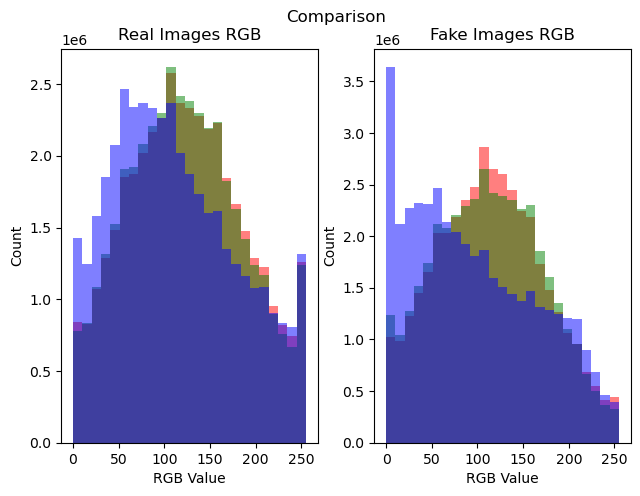

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison')
fig.tight_layout(pad=1.0)
my_alpha=0.5
ax1.hist(realimg_R, bins=25, color='red', alpha=my_alpha)
ax1.hist(realimg_G, bins=25, color='green', alpha=my_alpha)
ax1.hist(realimg_B, bins=25, color='blue', alpha=my_alpha)
ax1.set(xlabel='RGB Value', ylabel='Count', title = "Real Images RGB")

ax2.hist(fakeimg_R, bins=25, color='red', alpha=my_alpha)
ax2.hist(fakeimg_G, bins=25, color='green', alpha=my_alpha)
ax2.hist(fakeimg_B, bins=25, color='blue', alpha=my_alpha)
ax2.set(xlabel='RGB Value', ylabel='Count', title = "Fake Images RGB")



In [22]:
real_imgs_norm = real_imgs/255.0
fake_imgs_norm = fake_imgs/255.0

#Upper Left Pixel
Rf_vals_real = real_imgs_norm[:,0,0,0]
Gf_vals_real = real_imgs_norm[:,0,0,1]
Bf_vals_real = real_imgs_norm[:,0,0,2]

Rf_vals_fake = fake_imgs_norm[:,0,0,0]
Gf_vals_fake = fake_imgs_norm[:,0,0,1]
Bf_vals_fake = fake_imgs_norm[:,0,0,2]

#Center pixel
Rmid_vals_real = real_imgs_norm[:,16,16,0]
Gmid_vals_real = real_imgs_norm[:,16,16,1]
Bmid_vals_real = real_imgs_norm[:,16,16,2]

Rmid_vals_fake = fake_imgs_norm[:,16,16,0]
Gmid_vals_fake = fake_imgs_norm[:,16,16,1]
Bmid_vals_fake = fake_imgs_norm[:,16,16,2]

#Bottom Right Pixel
Rl_vals_real = real_imgs_norm[:,31,31,0]
Gl_vals_real = real_imgs_norm[:,31,31,1]
Bl_vals_real = real_imgs_norm[:,31,31,2]

Rl_vals_fake = fake_imgs_norm[:,31,31,0]
Gl_vals_fake = fake_imgs_norm[:,31,31,1]
Bl_vals_fake = fake_imgs_norm[:,31,31,2]

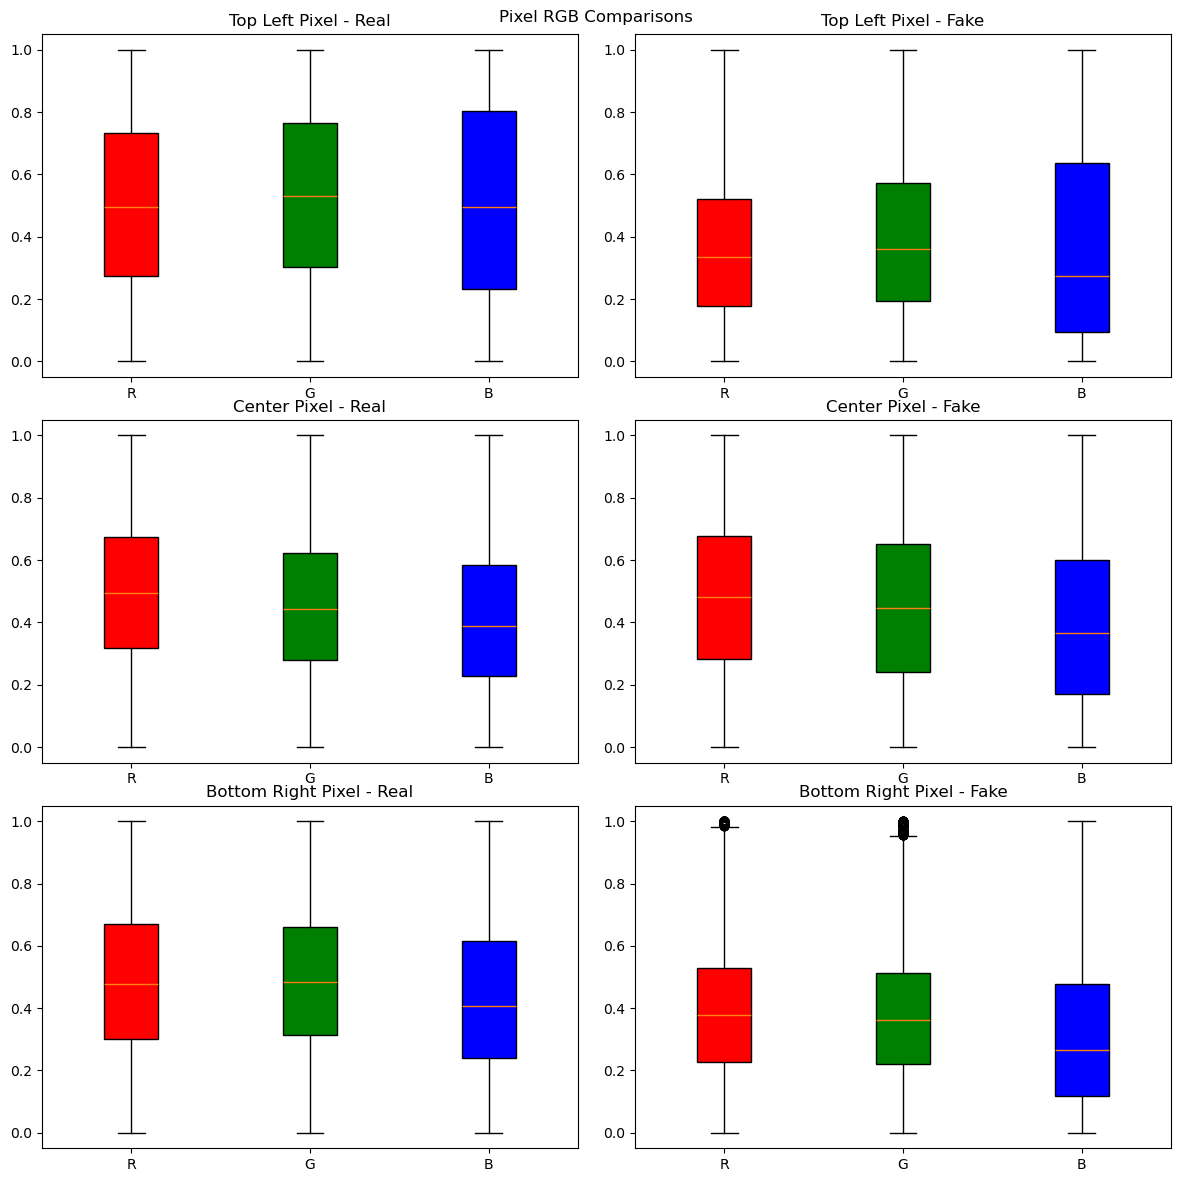

In [23]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Pixel RGB Comparisons')
fig.tight_layout(pad=1.0)

data00 = [Rf_vals_real, Gf_vals_real, Bf_vals_real]
data01 = [Rf_vals_fake, Gf_vals_fake, Bf_vals_fake]

data10 = [Rmid_vals_real, Gmid_vals_real, Bmid_vals_real]
data11 = [Rmid_vals_fake, Gmid_vals_fake, Bmid_vals_fake]

data20 = [Rl_vals_real, Gl_vals_real, Bl_vals_real]
data21 = [Rl_vals_fake, Gl_vals_fake, Bl_vals_fake]

bplot00 = ax1.boxplot(data00, patch_artist=True)
ax1.set(title = "Top Left Pixel - Real")
ax1.set_xticklabels(['R', 'G', 'B'])
bplot01 = ax2.boxplot(data01, patch_artist=True)
ax2.set(title = "Top Left Pixel - Fake")
ax2.set_xticklabels(['R', 'G', 'B'])


bplot10 = ax3.boxplot(data10, patch_artist=True)
ax3.set(title = "Center Pixel - Real")
ax3.set_xticklabels(['R', 'G', 'B'])
bplot11 = ax4.boxplot(data11, patch_artist=True)
ax4.set(title = "Center Pixel - Fake")
ax4.set_xticklabels(['R', 'G', 'B'])

bplot20 = ax5.boxplot(data20, patch_artist=True)
ax5.set(title = "Bottom Right Pixel - Real")
ax5.set_xticklabels(['R', 'G', 'B'])
bplot21 = ax6.boxplot(data21, patch_artist=True)
ax6.set(title = "Bottom Right Pixel - Fake")
ax6.set_xticklabels(['R', 'G', 'B'])


colors = ['red', 'green', 'blue']
for bplot in (bplot00, bplot01, bplot10, bplot11, bplot20, bplot21):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
plt.show()

# Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

rfmodel = RandomForestClassifier(random_state = 42)
rfmodel.fit(norm_train_imgs2, train_labels)

y_pred = rfmodel.predict(norm_val_imgs2)

accuracy_score(y_pred, val_labels)
print(classification_report(y_pred, val_labels))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     10612
           1       0.80      0.86      0.83      9388

    accuracy                           0.83     20000
   macro avg       0.83      0.84      0.83     20000
weighted avg       0.84      0.83      0.83     20000



In [21]:
accuracy_score(y_pred, val_labels)

0.83415

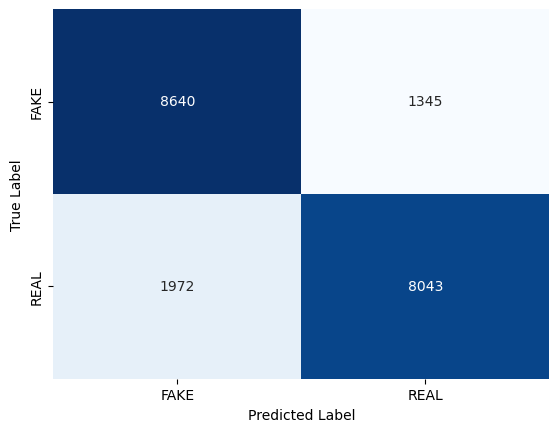

In [88]:
ax = sns.heatmap(confusion_matrix(val_labels, y_pred), annot=True, fmt='.0f', cmap='Blues', xticklabels=classes, yticklabels=classes,
                  cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50, 100, 150]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [None, 10, 20]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth
               }
print(random_grid)

{'n_estimators': [50, 100, 150], 'max_features': ['sqrt', 'log2'], 'max_depth': [None, 10, 20]}


In [23]:
rf_tune = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf_tune, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(norm_train_imgs2, train_labels)

C:\Users\Hannah\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, verbose=2)

In [24]:
bp = rf_random.best_params_
bp

{'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': None}

In [25]:
best_randomforest = rf_random.best_estimator_

In [26]:
best_randomforest

RandomForestClassifier(max_features='sqrt', n_estimators=150, random_state=42)

In [27]:
y_predbest = best_randomforest.predict(norm_val_imgs2)

In [29]:
accuracy_score(y_predbest, val_labels)

0.84005

In [30]:
print(classification_report(y_predbest, val_labels))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     10578
           1       0.81      0.86      0.84      9422

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



In [31]:
confusion_matrix(val_labels, y_predbest)

array([[8682, 1303],
       [1896, 8119]], dtype=int64)

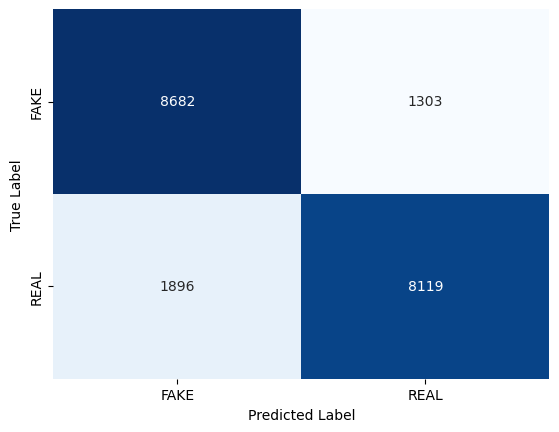

In [41]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(val_labels, y_predbest), annot=True, fmt='.0f', cmap='Blues', xticklabels=classes, yticklabels=classes,
                  cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [43]:
test_ds_rf = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "test",
  seed = 512,
  image_size = (img_height, img_width), 
  batch_size = 20000)
test_ds_rf

Found 20000 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [44]:
rf_test_list = list(test_ds_rf)
test_imgs = rf_test_list[0][0].numpy()
test_labels = rf_test_list[0][1].numpy()

In [45]:
norm_test_imgs = test_imgs/255.0
testsamples, testx, testy, testrgb = norm_test_imgs.shape
norm_test_imgs2 = norm_test_imgs.reshape((testsamples,testx*testy*testrgb))
norm_test_imgs2.shape

(20000, 3072)

In [46]:
final_y_pred = best_randomforest.predict(norm_test_imgs2)

In [47]:
accuracy_score(final_y_pred, test_labels)

0.8362

In [48]:
print(classification_report(final_y_pred, test_labels))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     10732
           1       0.80      0.86      0.83      9268

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



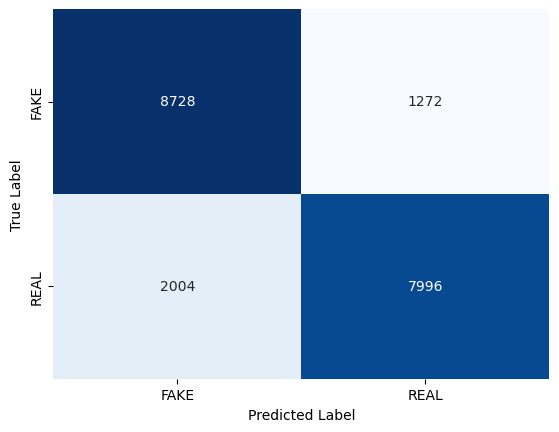

In [49]:
ax = sns.heatmap(confusion_matrix(test_labels, final_y_pred), annot=True, fmt='.0f', cmap='Blues', xticklabels=classes, yticklabels=classes,
                  cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

# SVM

In [3]:
from sklearn import svm

In [ ]:
rbfsvm = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(norm_train_imgs2, train_labels)

In [ ]:
y_pred_rbf = rbfsvm.predict(norm_val_imgs2)
accuracy_score(y_pred_rbf, val_labels)

In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(norm_train_imgs2, train_labels)

In [ ]:
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.001,0.1,1],
            'kernel':['rbf','poly']}

svc=svm.SVC()

model=GridSearchCV(svc,param_grid)

In [ ]:
model.fit(norm_train_imgs2, train_labels)